<a href="https://colab.research.google.com/github/Rotor-380/Kaggle/blob/main/Leopard_Classification_Kerass_fail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install phik

In [ ]:
!pip install catboost

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from phik.report import plot_correlation_matrix
from sklearn.metrics import mean_absolute_percentage_error
# from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [32]:
df_raw = pd.read_csv(r'/content/train.csv')

In [33]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13863 entries, 0 to 13862
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   13863 non-null  int64  
 1   age                  13863 non-null  int64  
 2   height(cm)           13863 non-null  int64  
 3   weight(kg)           13863 non-null  int64  
 4   waist(cm)            13863 non-null  float64
 5   eyesight(left)       13863 non-null  float64
 6   eyesight(right)      13863 non-null  float64
 7   hearing(left)        13863 non-null  float64
 8   hearing(right)       13863 non-null  float64
 9   systolic             13863 non-null  float64
 10  relaxation           13863 non-null  float64
 11  fasting blood sugar  13863 non-null  float64
 12  Cholesterol          13863 non-null  float64
 13  triglyceride         13863 non-null  float64
 14  HDL                  13863 non-null  float64
 15  LDL                  13863 non-null 

In [6]:
# строим зависимость по Фику
phik_overview = df_raw.phik_matrix()
phik_overview['smoking'].sort_values(ascending=False)

interval columns not set, guessing: ['ID', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'smoking']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable oral for analysis 1. Dropping this column
  warnings.warn(


smoking                1.000000
triglyceride           0.190617
age                    0.183296
Gtp                    0.142844
hemoglobin             0.112074
tartar                 0.104470
dental caries          0.089124
waist(cm)              0.062522
serum creatinine       0.055594
HDL                    0.050773
weight(kg)             0.042934
fasting blood sugar    0.041979
hearing(left)          0.035270
height(cm)             0.035266
Urine protein          0.030645
hearing(right)         0.024719
relaxation             0.023451
LDL                    0.022210
systolic               0.016464
Cholesterol            0.015907
ALT                    0.014651
AST                    0.001957
eyesight(right)        0.000000
eyesight(left)         0.000000
ID                     0.000000
Name: smoking, dtype: float64

In [754]:
df = df_raw.drop(['oral', 'ID'], axis=1).copy() # , 'eyesight(left)', 'eyesight(right)', 'AST', 'ALT', 'hearing(right)', 'relaxation'
df['tartar'] = df['tartar'].apply(lambda x: 1 if x == 'Y' else 0)

In [8]:
# Разделение данных по классам целевой переменной 'smoking'
non_smokers = df[df['smoking'] == 0]
smokers = df[df['smoking'] == 1]

filtered_df = non_smokers.copy()

In [9]:
for col in df.iloc[:, 1:].columns.to_list():
    if df[col].nunique() > 20:
        print(col)
        # Calculate IQR for BuildingArea
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        num_outliers = outliers.shape[0]

#         print(lower_bound, upper_bound, num_outliers)
#         print(df[col].nunique())
#         print()
        filtered_df = filtered_df[(filtered_df[col] >= lower_bound) & (filtered_df[col] <= upper_bound)]

merged_data = pd.concat([filtered_df, smokers], axis=0)
merged_data.shape

waist(cm)
systolic
relaxation
fasting blood sugar
Cholesterol
triglyceride
HDL
LDL
hemoglobin
serum creatinine
AST
ALT
Gtp


(11018, 24)

In [35]:
merged_data = df.copy()

In [11]:
merged_data['log_tr'] = merged_data['triglyceride'].apply(np.log)
merged_data['log_gtp'] = merged_data['Gtp'].apply(np.log)
merged_data['BMI'] = merged_data['weight(kg)'] / ((merged_data['height(cm)'] / 100) ** 2)
merged_data['middle_aged'] = (merged_data['age'] >= 40) & (merged_data['age'] <= 64)
merged_data['senior'] = merged_data['age'] >= 65
merged_data['middle_aged'] = merged_data['middle_aged'].apply(lambda x: 1 if x == True else 0)
merged_data['senior'] = merged_data['senior'].apply(lambda x: 1 if x == True else 0)
merged_data['log_tr'] = merged_data['triglyceride'].apply(np.log)
merged_data['log_gtp'] = merged_data['Gtp'].apply(np.log)
merged_data['log_log_alt'] = np.log(np.log(merged_data['ALT']))
merged_data['BMI_log_gtp'] = merged_data['BMI'].apply(np.log)


In [36]:
# строим зависимость по Фику
phik_overview = merged_data.phik_matrix()
phik_overview['smoking'].sort_values(ascending=False)

interval columns not set, guessing: ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'tartar', 'smoking']


smoking                1.000000
triglyceride           0.190617
age                    0.183296
Gtp                    0.142844
hemoglobin             0.112074
tartar                 0.104470
dental caries          0.089124
waist(cm)              0.062522
serum creatinine       0.055594
HDL                    0.050773
weight(kg)             0.042934
fasting blood sugar    0.041979
hearing(left)          0.035270
height(cm)             0.035266
Urine protein          0.030645
hearing(right)         0.024719
relaxation             0.023451
LDL                    0.022210
systolic               0.016464
Cholesterol            0.015907
ALT                    0.014651
AST                    0.001957
eyesight(right)        0.000000
eyesight(left)         0.000000
Name: smoking, dtype: float64

In [37]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13863 entries, 0 to 13862
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  13863 non-null  int64  
 1   height(cm)           13863 non-null  int64  
 2   weight(kg)           13863 non-null  int64  
 3   waist(cm)            13863 non-null  float64
 4   eyesight(left)       13863 non-null  float64
 5   eyesight(right)      13863 non-null  float64
 6   hearing(left)        13863 non-null  float64
 7   hearing(right)       13863 non-null  float64
 8   systolic             13863 non-null  float64
 9   relaxation           13863 non-null  float64
 10  fasting blood sugar  13863 non-null  float64
 11  Cholesterol          13863 non-null  float64
 12  triglyceride         13863 non-null  float64
 13  HDL                  13863 non-null  float64
 14  LDL                  13863 non-null  float64
 15  hemoglobin           13863 non-null 

In [733]:
from sklearn.model_selection import train_test_split

merged_data = df.copy() # =======================================================

X = merged_data.drop(['smoking'], axis=1) #
y = merged_data['smoking']

# polynomial_converter = PolynomialFeatures(degree=2, include_bias=False)
# pX = polynomial_converter.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [734]:
from tensorflow import keras
from tensorflow.keras import layers

In [735]:
print('TRAIN:', X_train.shape, y_train.shape)
print('TEST', X_test.shape, y_test.shape)

TRAIN: (11090, 23) (11090,)
TEST (2773, 23) (2773,)


In [736]:
from sklearn.preprocessing import MinMaxScaler

# Масштабирование признаков
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((11090, 23), (2773, 23))

In [737]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [738]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, f1_score

In [739]:
n_features = X_train.shape[1]

def create_classification_model():
    # Создание модели
    model = Sequential()
    model.add(Dense(9, activation='relu', input_shape=(n_features,)))
    model.add(Dropout(0.3))
    # model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.2), bias_regularizer=l2(0.2)))
    # model.add(Dropout(0.2))
    # model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.05, l2=0.051)))
    # model.add(Dropout(0.4))
    # model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.05, l2=0.051)))
    # model.add(Dropout(0.3))
    # model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05), bias_regularizer=l2(0.05)))
    # model.add(Dropout(0.4))
    # model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.3))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # Сигмоидная активация для бинарной классификации
    return model

In [740]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
from tensorflow.keras.optimizers import  Adadelta, Nadam
from tensorflow.keras import optimizers
from keras.regularizers import l1, l2, l1_l2

In [741]:
# Рассчитываем веса классов
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weights = {0: weights[0], 1: weights[1]}
class_weights

{0: 0.6265536723163841, 1: 2.4754464285714284}

In [742]:
# Оптимизатор
sgd = SGD(learning_rate=0.05, momentum=0.5, nesterov=True)
adam = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
rmsprop = RMSprop(learning_rate=0.01, rho=0.9, epsilon=1e-08)
adagrad = Adagrad(learning_rate=0.001, epsilon=1e-08)
nadam = Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
ftrl = optimizers.Ftrl(learning_rate=0.0001, l1_regularization_strength=0.1, l2_regularization_strength=0.0, beta=0.0)
adadelta = Adadelta(learning_rate=1.0, rho=0.95, epsilon=1e-07)

In [743]:
# Создание и компиляция модели
Keras_model = create_classification_model()
Keras_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# Создание объектов EarlyStopping и ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, min_lr=0.0001)

# Обучение модели
history = Keras_model.fit(X_train, y_train, epochs=300, batch_size=64, validation_split=0.2, verbose=0.5, callbacks=[early_stopping, reduce_lr], class_weight=class_weights)

# Предсказание на тестовой выборке
y_pred_probs = Keras_model.predict(X_test)

# Вычисление матрицы корреляции
corr_matrix = np.corrcoef(y_test, y_pred_probs[:, 0])

# Подбор оптимального порога для F1-меры
thresholds = np.linspace(0.1, 0.9, 200)
f1_scores = [f1_score(y_test, y_pred_probs > thr) for thr in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]
f1_optimal = f1_score(y_test, y_pred_probs > optimal_threshold)

corr_matrix[0, 1], optimal_threshold, f1_optimal

Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300
Epoch 29/300
Epoch 30/300
Epoch 31/300
Epoch 32/300
Epoch 33/300
Epoch 34/300
Epoch 35/300
Epoch 36/300
Epoch 37/300
Epoch 38/300
Epoch 39/300
Epoch 40/300
Epoch 41/300
Epoch 42/300
Epoch 43/300
Epoch 44/300
Epoch 45/300
Epoch 46/300
Epoch 47/300
Epoch 48/300
Epoch 49/300
Epoch 50/300
Epoch 51/300
Epoch 52/300
Epoch 53/300
Epoch 54/300
Epoch 55/300
Epoch 56/300
Epoch 57/300
Epoch 58/300
Epoch 59/300
Epoch 60/300
Epoch 61/300
Epoch 62/300
Epoch 63/300
Epoch 64/300
Epoch 65/300
Epoch 66/300
Epoch 67/300
Epoch 68/300
Epoch 69/300
Epoch 70/300
Epoch 71/300
Epoch 72/300
Epoch 73/300
Epoch 74/300
Epoch 75/300
Epoch 76/300
Epoch 77/300
Epoch 78

(0.2342049864588347, 0.4296482412060302, 0.40623428858722976)

In [744]:
from tensorflow.keras.metrics import Precision, Recall

precision = Precision()
recall = Recall()

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))


In [745]:
# Получение прогноза на валидационном наборе
f1#, conf_matrix

<function __main__.f1(y_true, y_pred)>

In [746]:
merged_data[X.columns.to_list()].values.astype('float32')

array([[ 65., 170.,  75., ..., 122.,   0.,   0.],
       [ 35., 170.,  85., ...,  40.,   0.,   1.],
       [ 70., 165.,  55., ...,  19.,   0.,   1.],
       ...,
       [ 65., 170.,  70., ...,  24.,   1.,   1.],
       [ 30., 160.,  80., ...,  31.,   0.,   0.],
       [ 60., 170.,  70., ...,  32.,   1.,   1.]], dtype=float32)

In [747]:
# X_np = df[X.columns.to_list()].values/
merged_data['pred_smoking'] = Keras_model.predict(merged_data[X.columns.to_list()].values.astype('float32'))

434/434 [==============================] - 1s 1ms/step


In [748]:
merged_data['pred_smoking']

0        1.653008e-14
1        5.959734e-01
2        0.000000e+00
3        1.901665e-17
4        1.314374e-17
             ...     
13858    4.563244e-19
13859    2.455803e-13
13860    0.000000e+00
13861    2.155936e-07
13862    3.490138e-33
Name: pred_smoking, Length: 13863, dtype: float32

In [749]:
merged_data['pred_smoking'] = (merged_data['pred_smoking'] > optimal_threshold).astype(int)

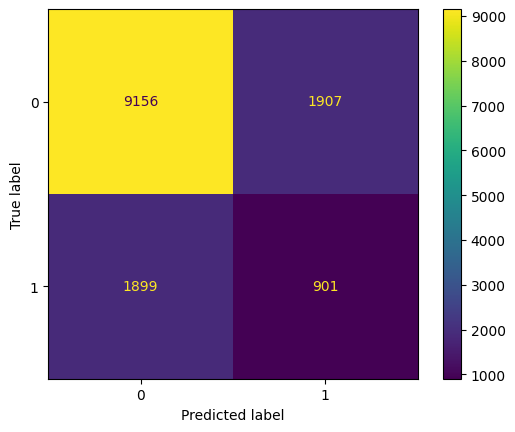

In [750]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
    classification_report, roc_auc_score

ConfusionMatrixDisplay(confusion_matrix(merged_data['smoking'], merged_data['pred_smoking'])).plot()

In [755]:
df_test = pd.read_csv(r'/content/test.csv')

In [756]:
df_test = df_test.drop(['oral', 'ID'], axis=1).copy()
df_test['tartar'] = df_test['tartar'].apply(lambda x: 1 if x == 'Y' else 0)

In [757]:
df_test = scaler.transform(df_test)

In [761]:
new_data_pred_proba = Keras_model.predict(df_test)

186/186 [==============================] - 0s 2ms/step


In [763]:
new_data_predictions = (new_data_pred_proba > optimal_threshold).astype(int)

In [764]:
new_data_predictions

array([[1],
       [0],
       [1],
       ...,
       [0],
       [1],
       [0]])

In [765]:
sample_submission_df = pd.read_csv(r'/content/sample_submission.csv')

In [766]:
sample_submission_df['smoking'] = new_data_predictions

In [767]:
sample_submission_df

,ID,smoking
0,19200,1
1,7784,0
2,11682,1
3,9949,0
4,9378,1
...,...,...
5937,17154,0
5938,19366,0
5939,1170,0
5940,9358,1


In [768]:
sample_submission_df['smoking'].value_counts()

1    2985
0    2957
Name: smoking, dtype: int64

In [769]:
sample_submission_df.to_csv('sample_submission_NN_1.csv', index=False)